**Copyright 2021 The TF-Agents Authors.**

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# SAC minitaur with the Actor-Learner API

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/agents/tutorials/7_SAC_minitaur_tutorial">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/7_SAC_minitaur_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/docs/tutorials/7_SAC_minitaur_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/agents/docs/tutorials/7_SAC_minitaur_tutorial.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


## Introduction

This example shows how to train a [Soft Actor Critic](https://arxiv.org/abs/1812.05905) agent on the [Minitaur](https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/bullet/minitaur.py) environment.

If you've worked through the [DQN Colab](https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb) this should feel very familiar. Notable changes include:

  * Changing the agent from DQN to SAC.
  * Training on Minitaur which is a much more complex environment than CartPole. The Minitaur environment aims to train a quadruped robot to move forward.
  * Using the TF-Agents Actor-Learner API for distributed Reinforcement Learning.

The API supports both distributed data collection using an experience replay buffer and variable container (parameter server) and distributed training across multiple devices. The API is designed to be very simple and modular. We utilize [Reverb](https://deepmind.com/research/open-source/Reverb) for both replay buffer and variable container and [TF DistributionStrategy API](https://www.tensorflow.org/guide/distributed_training) for distributed training on GPUs and TPUs.

If you haven't installed the following dependencies, run:

In [2]:
!sudo apt-get install -y xvfb ffmpeg
!pip install -q 'imageio==2.4.0'
!pip install -q matplotlib
!pip install -q tf-agents[reverb]
!pip install -q pybullet

The following packages were automatically installed and are no longer required:
  adwaita-icon-theme ca-certificates-java dconf-gsettings-backend
  dconf-service default-jre default-jre-headless dkms fonts-dejavu-extra
  freeglut3 freeglut3-dev g++-6 glib-networking glib-networking-common
  glib-networking-services gsettings-desktop-schemas gtk-update-icon-cache
  hicolor-icon-theme humanity-icon-theme java-common libaccinj64-9.1
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcairo-gobject2 libcolord2 libcudart9.1 libcufft9.1
  libcufftw9.1 libcups2 libcurand9.1 libcusolver9.1 libcusparse9.1 libdconf1
  libdrm-dev libegl-mesa0 libegl1 libegl1-mesa libepoxy0 libgbm1 libgif7
  libgl1-mesa-dev libgles1 libgles2 libglu1-mesa libglu1-mesa-dev
  libglvnd-core-dev libglvnd-dev libgtk-3-0 libgtk-3-common libgtk2.0-0
  libgtk2.0-common libice-dev libjansson4 libjson-glib-1.0-

The following NEW packages will be installed:
  ffmpeg i965-va-driver libaacs0 libass9 libavc1394-0 libavcodec57
  libavdevice57 libavfilter6 libavformat57 libavresample3 libavutil55
  libbdplus0 libbluray2 libbs2b0 libcaca0 libcdio-cdda2 libcdio-paranoia2
  libcdio17 libchromaprint1 libcrystalhd3 libdc1394-22 libfftw3-double3
  libflite1 libgme0 libgsm1 libiec61883-0 libjack-jackd2-0 libllvm10
  libmp3lame0 libmpg123-0 libmysofa0 libnorm1 libnuma1 libopenal-data
  libopenal1 libopenjp2-7 libopenmpt0 libopus0 libpgm-5.2-0 libpostproc54
  libraw1394-11 librubberband2 libsamplerate0 libsdl2-2.0-0 libshine3
  libsnappy1v5 libsndio6.1 libsodium23 libsoxr0 libspeex1 libssh-gcrypt-4
  libswresample2 libswscale4 libtheora0 libtwolame0 libva-drm2 libva-x11-2
  libva2 libvorbisfile3 libvpx5 libwavpack1 libwebpmux3 libx264-152
  libx265-146 libxss1 libxvidcore4 libzmq5 libzvbi-common libzvbi0
  mesa-va-drivers va-driver-all xvfb
The following packages will be upgraded:
  libdrm-amdgpu1 libdrm-co

7 upgraded, 72 newly installed, 0 to remove and 94 not upgraded.
Need to get 50.5 MB of archives.
After this operation, 199 MB of additional disk space will be used.
0% [Working]

Get:1 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libxss1 amd64 1:1.2.2-1 [8582 B]
Get:2 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdrm-common all 2.4.101-2~18.04.1 [5560 B]
Get:3 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdrm-dev amd64 2.4.101-2~18.04.1 [126 kB]
Get:4 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdrm-intel1 amd64 2.4.101-2~18.04.1 [60.0 kB]
Get:5 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdrm-radeon1 amd64 2.4.101-2~18.04.1 [21.7 kB]
Get:6 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdrm-nouveau2 amd64 2.4.101-2~18.04.1 [16.5 kB]
Get:7 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdrm-amdgpu1 amd64 2.4.101-2~18.04.1 [18.2 kB]
Get:8 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdrm2 amd64 2.4.101-2~18.04.1 [32.3 kB]
2% [Work

Get:9 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libnuma1 amd64 2.0.11-2.1ubuntu0.1 [22.0 kB]
3% [Waiting for headers]

Get:10 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libva2 amd64 2.1.0-3 [47.6 kB]
3% [Waiting for headers]

Get:11 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libva-drm2 amd64 2.1.0-3 [6880 B]
3% [Working]

Get:12 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libva-x11-2 amd64 2.1.0-3 [11.5 kB]
Get:13 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libavutil55 amd64 7:3.4.8-0ubuntu0.2 [190 kB]
4% [Waiting for headers]

Get:14 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libcrystalhd3 amd64 1:0.0~git20110715.fdd2f19-12 [45.8 kB]
5% [Waiting for headers]

Get:15 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libgsm1 amd64 1.0.13-4build1 [22.4 kB]
Get:16 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libmp3lame0 amd64 3.100-2 [136 kB]
5% [Waiting for headers]

Get:17 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libopenjp2-7 amd64 2.3.0-2build0.18.04.1 [145 kB]
Get:18 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libopus0 amd64 1.1.2-1ubuntu1 [159 kB]
6% [Waiting for headers]

Get:19 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libshine3 amd64 3.1.1-1 [22.9 kB]
7% [Working]

Get:20 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libsnappy1v5 amd64 1.1.7-1 [16.0 kB]
7% [Waiting for headers]

Get:21 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libspeex1 amd64 1.2~rc1.2-1ubuntu2 [52.1 kB]
7% [Waiting for headers]

Get:22 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libsoxr0 amd64 0.1.2-3 [65.9 kB]
Get:23 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libswresample2 amd64 7:3.4.8-0ubuntu0.2 [55.2 kB]
Get:24 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libtheora0 amd64 1.1.1+dfsg.1-14 [170 kB]
8% [24 libtheora0 12.3 kB/170 kB 7%]

8% [Waiting for headers]

Get:25 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libtwolame0 amd64 0.3.13-3 [46.7 kB]
Get:26 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libvpx5 amd64 1.7.0-3ubuntu0.18.04.1 [796 kB]
Get:27 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libwavpack1 amd64 5.1.0-2ubuntu1.5 [76.8 kB]
Get:28 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libwebpmux3 amd64 0.6.1-2 [19.6 kB]
11% [Working]

11% [Waiting for headers]

Get:29 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libx264-152 amd64 2:0.152.2854+gite9a5903-2 [609 kB]
12% [Waiting for headers]

Get:30 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libx265-146 amd64 2.6-3 [1026 kB]
14% [Waiting for headers]

Get:31 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libxvidcore4 amd64 2:1.3.5-1 [200 kB]
15% [Waiting for headers]                                      665 kB/s 1min 9s

Get:32 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libzvbi-common all 0.2.35-13 [32.1 kB]
15% [Waiting for headers]                                      665 kB/s 1min 9s

Get:33 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libzvbi0 amd64 0.2.35-13 [235 kB]
Get:34 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libavcodec57 amd64 7:3.4.8-0ubuntu0.2 [4595 kB]
15% [34 libavcodec57 11.2 kB/4595 kB 0%]                       665 kB/s 1min 9s

Get:35 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libraw1394-11 amd64 2.1.2-1 [30.7 kB]
Get:36 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libavc1394-0 amd64 0.5.4-4build1 [16.1 kB]
Get:37 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libass9 amd64 1:0.14.0-1 [88.2 kB]
24% [Waiting for headers]                                      665 kB/s 1min 2s

24% [Waiting for headers]                                      665 kB/s 1min 2s

Get:38 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libbluray2 amd64 1:1.0.2-3 [141 kB]
24% [Waiting for headers]                                      665 kB/s 1min 1s

Get:39 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libchromaprint1 amd64 1.4.3-1 [36.8 kB]
25% [Waiting for headers]                                      665 kB/s 1min 1s

Get:40 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libgme0 amd64 0.6.2-1 [121 kB]
25% [Waiting for headers]                                      665 kB/s 1min 1s

Get:41 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libmpg123-0 amd64 1.25.10-1 [125 kB]
26% [Waiting for headers]                                      665 kB/s 1min 1s

Get:42 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libvorbisfile3 amd64 1.3.5-4.2 [16.0 kB]
26% [Waiting for headers]                                      665 kB/s 1min 1s

Get:43 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libopenmpt0 amd64 0.3.6-1 [561 kB]
Get:44 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libssh-gcrypt-4 amd64 0.8.0~20170825.94fa1e38-1ubuntu0.7 [172 kB]
Get:45 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libavformat57 amd64 7:3.4.8-0ubuntu0.2 [953 kB]
Get:46 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libavresample3 amd64 7:3.4.8-0ubuntu0.2 [52.6 kB]
30% [Waiting for headers]                                          665 kB/s 58s

Get:47 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libbs2b0 amd64 3.1.0+dfsg-2.2 [10.5 kB]
30% [Waiting for headers]                                          665 kB/s 58s

Get:48 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libflite1 amd64 2.1-release-1 [12.8 MB]
30% [48 libflite1 12.3 kB/12.8 MB 0%]                              665 kB/s 58s

Get:49 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libmysofa0 amd64 0.6~dfsg0-3+deb10u1build1 [38.5 kB]
Get:50 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libpostproc54 amd64 7:3.4.8-0ubuntu0.2 [50.3 kB]
Get:51 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libfftw3-double3 amd64 3.3.7-1 [735 kB]
Get:52 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libsamplerate0 amd64 0.1.9-1 [938 kB]
Get:53 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 librubberband2 amd64 1.8.1-7ubuntu2 [86.7 kB]
Get:54 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libswscale4 amd64 7:3.4.8-0ubuntu0.2 [150 kB]
Get:55 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libnorm1 amd64 1.5r6+dfsg1-6 [224 kB]
56% [Waiting for headers]                                          665 kB/s 36s

Get:56 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libpgm-5.2-0 amd64 5.2.122~dfsg-2 [157 kB]
Get:57 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libsodium23 amd64 1.0.16-2 [143 kB]
Get:58 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libzmq5 amd64 4.2.5-1ubuntu0.2 [221 kB]
Get:59 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libavfilter6 amd64 7:3.4.8-0ubuntu0.2 [874 kB]
Get:60 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcaca0 amd64 0.99.beta19-2ubuntu0.18.04.1 [203 kB]
Get:61 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libcdio17 amd64 1.0.0-2ubuntu2 [58.8 kB]
Get:62 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libcdio-cdda2 amd64 10.2+0.94+2-2build1 [17.7 kB]
Get:63 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libcdio-paranoia2 amd64 10.2+0.94+2-2build1 [17.2 kB]
61% [Working]   

Get:64 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libdc1394-22 amd64 2.2.5-1 [77.5 kB]
Get:65 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libiec61883-0 amd64 1.2.0-2 [23.5 kB]
Get:66 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libjack-jackd2-0 amd64 1.9.12~dfsg-2 [263 kB]
Get:67 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libopenal-data all 1:1.18.2-2 [102 kB]
62% [67 libopenal-data 39.4 kB/102 kB 39%]                         665 kB/s 33s

Get:68 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libsndio6.1 amd64 1.1.0-3 [23.4 kB]
Get:69 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libopenal1 amd64 1:1.18.2-2 [266 kB]
Get:70 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libsdl2-2.0-0 amd64 2.0.8+dfsg1-1ubuntu1.18.04.4 [382 kB]
Get:71 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libavdevice57 amd64 7:3.4.8-0ubuntu0.2 [74.9 kB]
Get:72 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 ffmpeg amd64 7:3.4.8-0ubuntu0.2 [1587 kB]
67% [Waiting for headers]                                          665 kB/s 29s

Get:73 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libaacs0 amd64 0.9.0-1 [51.4 kB]
68% [Waiting for headers]                                          665 kB/s 29s

Get:74 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libbdplus0 amd64 0.1.2-2 [46.6 kB]
Get:75 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libllvm10 amd64 1:10.0.0-4ubuntu1~18.04.2 [15.4 MB]
68% [75 libllvm10 12.3 kB/15.4 MB 0%]                              665 kB/s 29s

93% [Waiting for headers]                                           665 kB/s 6s

Get:76 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 mesa-va-drivers amd64 20.0.8-0ubuntu1~18.04.1 [2376 kB]
93% [76 mesa-va-drivers 20.2 kB/2376 kB 1%]                         665 kB/s 6s

97% [Waiting for headers]                                           665 kB/s 2s

Get:77 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 i965-va-driver amd64 2.1.0-0ubuntu1 [925 kB]
97% [77 i965-va-driver 65.5 kB/925 kB 7%]                           665 kB/s 2s

98% [Waiting for headers]                                           665 kB/s 1s

Get:78 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 va-driver-all amd64 2.1.0-3 [4376 B]
99% [Waiting for headers]                                          7342 kB/s 0s

Get:79 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 50.5 MB in 13s (3983 kB/s)


Extracting templates from packages: 37%

Extracting templates from packages: 75%

Extracting templates from packages: 100%


Selecting previously unselected package libxss1:amd64.


(Reading database ... 243746 files and directories currently installed.)
Preparing to unpack .../00-libxss1_1%3a1.2.2-1_amd64.deb ...
Unpacking libxss1:amd64 (1:1.2.2-1) ...


Preparing to unpack .../01-libdrm-common_2.4.101-2~18.04.1_all.deb ...
Unpacking libdrm-common (2.4.101-2~18.04.1) over (2.4.99-1ubuntu1~18.04.2) ...


Preparing to unpack .../02-libdrm-dev_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-dev:amd64 (2.4.101-2~18.04.1) over (2.4.99-1ubuntu1~18.04.2) ...


Preparing to unpack .../03-libdrm-intel1_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-intel1:amd64 (2.4.101-2~18.04.1) over (2.4.99-1ubuntu1~18.04.2) ...


Preparing to unpack .../04-libdrm-radeon1_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-radeon1:amd64 (2.4.101-2~18.04.1) over (2.4.99-1ubuntu1~18.04.2) ...


Preparing to unpack .../05-libdrm-nouveau2_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-nouveau2:amd64 (2.4.101-2~18.04.1) over (2.4.99-1ubuntu1~18.04.2) ...


Preparing to unpack .../06-libdrm-amdgpu1_2.4.101-2~18.04.1_amd64.deb ...


Unpacking libdrm-amdgpu1:amd64 (2.4.101-2~18.04.1) over (2.4.99-1ubuntu1~18.04.2) ...


Preparing to unpack .../07-libdrm2_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm2:amd64 (2.4.101-2~18.04.1) over (2.4.99-1ubuntu1~18.04.2) ...


Selecting previously unselected package libnuma1:amd64.
Preparing to unpack .../08-libnuma1_2.0.11-2.1ubuntu0.1_amd64.deb ...
Unpacking libnuma1:amd64 (2.0.11-2.1ubuntu0.1) ...


Selecting previously unselected package libva2:amd64.
Preparing to unpack .../09-libva2_2.1.0-3_amd64.deb ...


Unpacking libva2:amd64 (2.1.0-3) ...
Selecting previously unselected package libva-drm2:amd64.


Preparing to unpack .../10-libva-drm2_2.1.0-3_amd64.deb ...
Unpacking libva-drm2:amd64 (2.1.0-3) ...


Selecting previously unselected package libva-x11-2:amd64.
Preparing to unpack .../11-libva-x11-2_2.1.0-3_amd64.deb ...
Unpacking libva-x11-2:amd64 (2.1.0-3) ...


Selecting previously unselected package libavutil55:amd64.
Preparing to unpack .../12-libavutil55_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libavutil55:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libcrystalhd3:amd64.


Preparing to unpack .../13-libcrystalhd3_1%3a0.0~git20110715.fdd2f19-12_amd64.deb ...
Unpacking libcrystalhd3:amd64 (1:0.0~git20110715.fdd2f19-12) ...


Selecting previously unselected package libgsm1:amd64.
Preparing to unpack .../14-libgsm1_1.0.13-4build1_amd64.deb ...
Unpacking libgsm1:amd64 (1.0.13-4build1) ...


Selecting previously unselected package libmp3lame0:amd64.
Preparing to unpack .../15-libmp3lame0_3.100-2_amd64.deb ...
Unpacking libmp3lame0:amd64 (3.100-2) ...


Selecting previously unselected package libopenjp2-7:amd64.


Preparing to unpack .../16-libopenjp2-7_2.3.0-2build0.18.04.1_amd64.deb ...
Unpacking libopenjp2-7:amd64 (2.3.0-2build0.18.04.1) ...


Selecting previously unselected package libopus0:amd64.
Preparing to unpack .../17-libopus0_1.1.2-1ubuntu1_amd64.deb ...
Unpacking libopus0:amd64 (1.1.2-1ubuntu1) ...


Selecting previously unselected package libshine3:amd64.


Preparing to unpack .../18-libshine3_3.1.1-1_amd64.deb ...
Unpacking libshine3:amd64 (3.1.1-1) ...


Selecting previously unselected package libsnappy1v5:amd64.
Preparing to unpack .../19-libsnappy1v5_1.1.7-1_amd64.deb ...
Unpacking libsnappy1v5:amd64 (1.1.7-1) ...


Selecting previously unselected package libspeex1:amd64.
Preparing to unpack .../20-libspeex1_1.2~rc1.2-1ubuntu2_amd64.deb ...
Unpacking libspeex1:amd64 (1.2~rc1.2-1ubuntu2) ...


Selecting previously unselected package libsoxr0:amd64.
Preparing to unpack .../21-libsoxr0_0.1.2-3_amd64.deb ...


Unpacking libsoxr0:amd64 (0.1.2-3) ...
Selecting previously unselected package libswresample2:amd64.


Preparing to unpack .../22-libswresample2_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libswresample2:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libtheora0:amd64.
Preparing to unpack .../23-libtheora0_1.1.1+dfsg.1-14_amd64.deb ...
Unpacking libtheora0:amd64 (1.1.1+dfsg.1-14) ...


Selecting previously unselected package libtwolame0:amd64.


Preparing to unpack .../24-libtwolame0_0.3.13-3_amd64.deb ...
Unpacking libtwolame0:amd64 (0.3.13-3) ...


Selecting previously unselected package libvpx5:amd64.
Preparing to unpack .../25-libvpx5_1.7.0-3ubuntu0.18.04.1_amd64.deb ...
Unpacking libvpx5:amd64 (1.7.0-3ubuntu0.18.04.1) ...


Selecting previously unselected package libwavpack1:amd64.
Preparing to unpack .../26-libwavpack1_5.1.0-2ubuntu1.5_amd64.deb ...
Unpacking libwavpack1:amd64 (5.1.0-2ubuntu1.5) ...


Selecting previously unselected package libwebpmux3:amd64.


Preparing to unpack .../27-libwebpmux3_0.6.1-2_amd64.deb ...
Unpacking libwebpmux3:amd64 (0.6.1-2) ...
Selecting previously unselected package libx264-152:amd64.


Preparing to unpack .../28-libx264-152_2%3a0.152.2854+gite9a5903-2_amd64.deb ...
Unpacking libx264-152:amd64 (2:0.152.2854+gite9a5903-2) ...


Selecting previously unselected package libx265-146:amd64.
Preparing to unpack .../29-libx265-146_2.6-3_amd64.deb ...


Unpacking libx265-146:amd64 (2.6-3) ...


Selecting previously unselected package libxvidcore4:amd64.
Preparing to unpack .../30-libxvidcore4_2%3a1.3.5-1_amd64.deb ...
Unpacking libxvidcore4:amd64 (2:1.3.5-1) ...


Selecting previously unselected package libzvbi-common.
Preparing to unpack .../31-libzvbi-common_0.2.35-13_all.deb ...
Unpacking libzvbi-common (0.2.35-13) ...


Selecting previously unselected package libzvbi0:amd64.
Preparing to unpack .../32-libzvbi0_0.2.35-13_amd64.deb ...
Unpacking libzvbi0:amd64 (0.2.35-13) ...


Selecting previously unselected package libavcodec57:amd64.
Preparing to unpack .../33-libavcodec57_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libavcodec57:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libraw1394-11:amd64.
Preparing to unpack .../34-libraw1394-11_2.1.2-1_amd64.deb ...
Unpacking libraw1394-11:amd64 (2.1.2-1) ...


Selecting previously unselected package libavc1394-0:amd64.


Preparing to unpack .../35-libavc1394-0_0.5.4-4build1_amd64.deb ...
Unpacking libavc1394-0:amd64 (0.5.4-4build1) ...
Selecting previously unselected package libass9:amd64.


Preparing to unpack .../36-libass9_1%3a0.14.0-1_amd64.deb ...
Unpacking libass9:amd64 (1:0.14.0-1) ...


Selecting previously unselected package libbluray2:amd64.
Preparing to unpack .../37-libbluray2_1%3a1.0.2-3_amd64.deb ...
Unpacking libbluray2:amd64 (1:1.0.2-3) ...


Selecting previously unselected package libchromaprint1:amd64.


Preparing to unpack .../38-libchromaprint1_1.4.3-1_amd64.deb ...
Unpacking libchromaprint1:amd64 (1.4.3-1) ...


Selecting previously unselected package libgme0:amd64.
Preparing to unpack .../39-libgme0_0.6.2-1_amd64.deb ...
Unpacking libgme0:amd64 (0.6.2-1) ...


Selecting previously unselected package libmpg123-0:amd64.


Preparing to unpack .../40-libmpg123-0_1.25.10-1_amd64.deb ...
Unpacking libmpg123-0:amd64 (1.25.10-1) ...


Selecting previously unselected package libvorbisfile3:amd64.
Preparing to unpack .../41-libvorbisfile3_1.3.5-4.2_amd64.deb ...
Unpacking libvorbisfile3:amd64 (1.3.5-4.2) ...


Selecting previously unselected package libopenmpt0:amd64.
Preparing to unpack .../42-libopenmpt0_0.3.6-1_amd64.deb ...
Unpacking libopenmpt0:amd64 (0.3.6-1) ...


Selecting previously unselected package libssh-gcrypt-4:amd64.
Preparing to unpack .../43-libssh-gcrypt-4_0.8.0~20170825.94fa1e38-1ubuntu0.7_amd64.deb ...
Unpacking libssh-gcrypt-4:amd64 (0.8.0~20170825.94fa1e38-1ubuntu0.7) ...


Selecting previously unselected package libavformat57:amd64.


Preparing to unpack .../44-libavformat57_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libavformat57:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libavresample3:amd64.


Preparing to unpack .../45-libavresample3_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libavresample3:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libbs2b0:amd64.
Preparing to unpack .../46-libbs2b0_3.1.0+dfsg-2.2_amd64.deb ...
Unpacking libbs2b0:amd64 (3.1.0+dfsg-2.2) ...


Selecting previously unselected package libflite1:amd64.


Preparing to unpack .../47-libflite1_2.1-release-1_amd64.deb ...
Unpacking libflite1:amd64 (2.1-release-1) ...


Selecting previously unselected package libmysofa0:amd64.
Preparing to unpack .../48-libmysofa0_0.6~dfsg0-3+deb10u1build1_amd64.deb ...
Unpacking libmysofa0:amd64 (0.6~dfsg0-3+deb10u1build1) ...


Selecting previously unselected package libpostproc54:amd64.
Preparing to unpack .../49-libpostproc54_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libpostproc54:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libfftw3-double3:amd64.
Preparing to unpack .../50-libfftw3-double3_3.3.7-1_amd64.deb ...
Unpacking libfftw3-double3:amd64 (3.3.7-1) ...


Selecting previously unselected package libsamplerate0:amd64.
Preparing to unpack .../51-libsamplerate0_0.1.9-1_amd64.deb ...
Unpacking libsamplerate0:amd64 (0.1.9-1) ...


Selecting previously unselected package librubberband2:amd64.


Preparing to unpack .../52-librubberband2_1.8.1-7ubuntu2_amd64.deb ...
Unpacking librubberband2:amd64 (1.8.1-7ubuntu2) ...


Selecting previously unselected package libswscale4:amd64.
Preparing to unpack .../53-libswscale4_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libswscale4:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libnorm1:amd64.


Preparing to unpack .../54-libnorm1_1.5r6+dfsg1-6_amd64.deb ...
Unpacking libnorm1:amd64 (1.5r6+dfsg1-6) ...


Selecting previously unselected package libpgm-5.2-0:amd64.


Preparing to unpack .../55-libpgm-5.2-0_5.2.122~dfsg-2_amd64.deb ...
Unpacking libpgm-5.2-0:amd64 (5.2.122~dfsg-2) ...


Selecting previously unselected package libsodium23:amd64.
Preparing to unpack .../56-libsodium23_1.0.16-2_amd64.deb ...
Unpacking libsodium23:amd64 (1.0.16-2) ...


Selecting previously unselected package libzmq5:amd64.
Preparing to unpack .../57-libzmq5_4.2.5-1ubuntu0.2_amd64.deb ...
Unpacking libzmq5:amd64 (4.2.5-1ubuntu0.2) ...


Selecting previously unselected package libavfilter6:amd64.


Preparing to unpack .../58-libavfilter6_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libavfilter6:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libcaca0:amd64.
Preparing to unpack .../59-libcaca0_0.99.beta19-2ubuntu0.18.04.1_amd64.deb ...
Unpacking libcaca0:amd64 (0.99.beta19-2ubuntu0.18.04.1) ...


Selecting previously unselected package libcdio17:amd64.
Preparing to unpack .../60-libcdio17_1.0.0-2ubuntu2_amd64.deb ...
Unpacking libcdio17:amd64 (1.0.0-2ubuntu2) ...


Selecting previously unselected package libcdio-cdda2:amd64.
Preparing to unpack .../61-libcdio-cdda2_10.2+0.94+2-2build1_amd64.deb ...
Unpacking libcdio-cdda2:amd64 (10.2+0.94+2-2build1) ...


Selecting previously unselected package libcdio-paranoia2:amd64.


Preparing to unpack .../62-libcdio-paranoia2_10.2+0.94+2-2build1_amd64.deb ...
Unpacking libcdio-paranoia2:amd64 (10.2+0.94+2-2build1) ...


Selecting previously unselected package libdc1394-22:amd64.
Preparing to unpack .../63-libdc1394-22_2.2.5-1_amd64.deb ...
Unpacking libdc1394-22:amd64 (2.2.5-1) ...


Selecting previously unselected package libiec61883-0:amd64.
Preparing to unpack .../64-libiec61883-0_1.2.0-2_amd64.deb ...
Unpacking libiec61883-0:amd64 (1.2.0-2) ...


Selecting previously unselected package libjack-jackd2-0:amd64.


Preparing to unpack .../65-libjack-jackd2-0_1.9.12~dfsg-2_amd64.deb ...
Unpacking libjack-jackd2-0:amd64 (1.9.12~dfsg-2) ...


Selecting previously unselected package libopenal-data.
Preparing to unpack .../66-libopenal-data_1%3a1.18.2-2_all.deb ...
Unpacking libopenal-data (1:1.18.2-2) ...


Selecting previously unselected package libsndio6.1:amd64.


Preparing to unpack .../67-libsndio6.1_1.1.0-3_amd64.deb ...
Unpacking libsndio6.1:amd64 (1.1.0-3) ...


Selecting previously unselected package libopenal1:amd64.
Preparing to unpack .../68-libopenal1_1%3a1.18.2-2_amd64.deb ...
Unpacking libopenal1:amd64 (1:1.18.2-2) ...


Selecting previously unselected package libsdl2-2.0-0:amd64.
Preparing to unpack .../69-libsdl2-2.0-0_2.0.8+dfsg1-1ubuntu1.18.04.4_amd64.deb ...
Unpacking libsdl2-2.0-0:amd64 (2.0.8+dfsg1-1ubuntu1.18.04.4) ...


Selecting previously unselected package libavdevice57:amd64.
Preparing to unpack .../70-libavdevice57_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libavdevice57:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package ffmpeg.


Preparing to unpack .../71-ffmpeg_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking ffmpeg (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libaacs0:amd64.
Preparing to unpack .../72-libaacs0_0.9.0-1_amd64.deb ...
Unpacking libaacs0:amd64 (0.9.0-1) ...


Selecting previously unselected package libbdplus0:amd64.


Preparing to unpack .../73-libbdplus0_0.1.2-2_amd64.deb ...
Unpacking libbdplus0:amd64 (0.1.2-2) ...


Selecting previously unselected package libllvm10:amd64.
Preparing to unpack .../74-libllvm10_1%3a10.0.0-4ubuntu1~18.04.2_amd64.deb ...
Unpacking libllvm10:amd64 (1:10.0.0-4ubuntu1~18.04.2) ...


Selecting previously unselected package mesa-va-drivers:amd64.
Preparing to unpack .../75-mesa-va-drivers_20.0.8-0ubuntu1~18.04.1_amd64.deb ...
Unpacking mesa-va-drivers:amd64 (20.0.8-0ubuntu1~18.04.1) ...


Selecting previously unselected package i965-va-driver:amd64.


Preparing to unpack .../76-i965-va-driver_2.1.0-0ubuntu1_amd64.deb ...
Unpacking i965-va-driver:amd64 (2.1.0-0ubuntu1) ...


Selecting previously unselected package va-driver-all:amd64.
Preparing to unpack .../77-va-driver-all_2.1.0-3_amd64.deb ...
Unpacking va-driver-all:amd64 (2.1.0-3) ...


Selecting previously unselected package xvfb.
Preparing to unpack .../78-xvfb_2%3a1.19.6-1ubuntu4.8_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.8) ...


Setting up libvorbisfile3:amd64 (1.3.5-4.2) ...


Setting up libpgm-5.2-0:amd64 (5.2.122~dfsg-2) ...
Setting up libtwolame0:amd64 (0.3.13-3) ...
Setting up libraw1394-11:amd64 (2.1.2-1) ...
Setting up libx264-152:amd64 (2:0.152.2854+gite9a5903-2) ...
Setting up libopenjp2-7:amd64 (2.3.0-2build0.18.04.1) ...


Setting up libllvm10:amd64 (1:10.0.0-4ubuntu1~18.04.2) ...
Setting up libwavpack1:amd64 (5.1.0-2ubuntu1.5) ...
Setting up xvfb (2:1.19.6-1ubuntu4.8) ...
Setting up libaacs0:amd64 (0.9.0-1) ...


Setting up libnuma1:amd64 (2.0.11-2.1ubuntu0.1) ...
Setting up libflite1:amd64 (2.1-release-1) ...
Setting up libsoxr0:amd64 (0.1.2-3) ...
Setting up libssh-gcrypt-4:amd64 (0.8.0~20170825.94fa1e38-1ubuntu0.7) ...


Setting up libxss1:amd64 (1:1.2.2-1) ...
Setting up libass9:amd64 (1:0.14.0-1) ...
Setting up libbluray2:amd64 (1:1.0.2-3) ...
Setting up libdc1394-22:amd64 (2.2.5-1) ...


Setting up libshine3:amd64 (3.1.1-1) ...
Setting up libva2:amd64 (2.1.0-3) ...
Setting up libiec61883-0:amd64 (1.2.0-2) ...
Setting up libspeex1:amd64 (1.2~rc1.2-1ubuntu2) ...


Setting up libfftw3-double3:amd64 (3.3.7-1) ...
Setting up libxvidcore4:amd64 (2:1.3.5-1) ...
Setting up libopus0:amd64 (1.1.2-1ubuntu1) ...
Setting up libx265-146:amd64 (2.6-3) ...
Setting up libopenal-data (1:1.18.2-2) ...


Setting up libdrm-common (2.4.101-2~18.04.1) ...
Setting up libbs2b0:amd64 (3.1.0+dfsg-2.2) ...
Setting up libnorm1:amd64 (1.5r6+dfsg1-6) ...
Setting up libsodium23:amd64 (1.0.16-2) ...


Setting up libmp3lame0:amd64 (3.100-2) ...
Setting up libcrystalhd3:amd64 (1:0.0~git20110715.fdd2f19-12) ...
Setting up libwebpmux3:amd64 (0.6.1-2) ...
Setting up libsnappy1v5:amd64 (1.1.7-1) ...


Setting up libavc1394-0:amd64 (0.5.4-4build1) ...
Setting up libzvbi-common (0.2.35-13) ...
Setting up libvpx5:amd64 (1.7.0-3ubuntu0.18.04.1) ...
Setting up libgme0:amd64 (0.6.2-1) ...


Setting up libbdplus0:amd64 (0.1.2-2) ...
Setting up libzvbi0:amd64 (0.2.35-13) ...
Setting up libcaca0:amd64 (0.99.beta19-2ubuntu0.18.04.1) ...
Setting up libsamplerate0:amd64 (0.1.9-1) ...
Setting up libsndio6.1:amd64 (1.1.0-3) ...


Setting up libtheora0:amd64 (1.1.1+dfsg.1-14) ...
Setting up libmpg123-0:amd64 (1.25.10-1) ...
Setting up libgsm1:amd64 (1.0.13-4build1) ...
Setting up libmysofa0:amd64 (0.6~dfsg0-3+deb10u1build1) ...


Setting up libcdio17:amd64 (1.0.0-2ubuntu2) ...
Setting up libzmq5:amd64 (4.2.5-1ubuntu0.2) ...
Setting up libopenmpt0:amd64 (0.3.6-1) ...
Setting up libcdio-cdda2:amd64 (10.2+0.94+2-2build1) ...


Setting up libdrm2:amd64 (2.4.101-2~18.04.1) ...
Setting up libdrm-intel1:amd64 (2.4.101-2~18.04.1) ...
Setting up librubberband2:amd64 (1.8.1-7ubuntu2) ...
Setting up libsdl2-2.0-0:amd64 (2.0.8+dfsg1-1ubuntu1.18.04.4) ...


Setting up libcdio-paranoia2:amd64 (10.2+0.94+2-2build1) ...
Setting up libva-drm2:amd64 (2.1.0-3) ...
Setting up libjack-jackd2-0:amd64 (1.9.12~dfsg-2) ...
Setting up libopenal1:amd64 (1:1.18.2-2) ...
Setting up libdrm-radeon1:amd64 (2.4.101-2~18.04.1) ...


Setting up libva-x11-2:amd64 (2.1.0-3) ...
Setting up libdrm-nouveau2:amd64 (2.4.101-2~18.04.1) ...
Setting up libavutil55:amd64 (7:3.4.8-0ubuntu0.2) ...
Setting up libdrm-amdgpu1:amd64 (2.4.101-2~18.04.1) ...
Setting up libdrm-dev:amd64 (2.4.101-2~18.04.1) ...


Setting up libswresample2:amd64 (7:3.4.8-0ubuntu0.2) ...
Setting up i965-va-driver:amd64 (2.1.0-0ubuntu1) ...
Setting up libswscale4:amd64 (7:3.4.8-0ubuntu0.2) ...
Setting up mesa-va-drivers:amd64 (20.0.8-0ubuntu1~18.04.1) ...
Setting up libpostproc54:amd64 (7:3.4.8-0ubuntu0.2) ...


Setting up libavresample3:amd64 (7:3.4.8-0ubuntu0.2) ...
Setting up libavcodec57:amd64 (7:3.4.8-0ubuntu0.2) ...
Setting up va-driver-all:amd64 (2.1.0-3) ...
Setting up libchromaprint1:amd64 (1.4.3-1) ...
Setting up libavformat57:amd64 (7:3.4.8-0ubuntu0.2) ...


Setting up libavfilter6:amd64 (7:3.4.8-0ubuntu0.2) ...
Setting up libavdevice57:amd64 (7:3.4.8-0ubuntu0.2) ...
Setting up ffmpeg (7:3.4.8-0ubuntu0.2) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...


Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


## Setup

First we will import the different tools that we need.

In [3]:
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import os
import reverb
import tempfile
import PIL.Image

import tensorflow as tf

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.environments import suite_pybullet
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.train import actor
from tf_agents.train import learner
from tf_agents.train import triggers
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils

tempdir = tempfile.gettempdir()

## Hyperparameters

In [4]:
env_name = "MinitaurBulletEnv-v0" # @param {type:"string"}

# Use "num_iterations = 1e6" for better results (2 hrs)
# 1e5 is just so this doesn't take too long (1 hr)
num_iterations = 100000 # @param {type:"integer"}

initial_collect_steps = 10000 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 10000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

log_interval = 5000 # @param {type:"integer"}

num_eval_episodes = 20 # @param {type:"integer"}
eval_interval = 10000 # @param {type:"integer"}

policy_save_interval = 5000 # @param {type:"integer"}

## Environment

Environments in RL represent the task or problem that we are trying to solve. Standard environments can be easily created in TF-Agents using `suites`. We have different `suites` for loading environments from sources such as the OpenAI Gym, Atari, DM Control, etc., given a string environment name.

Now let's load the Minituar environment from the Pybullet suite.

current_dir=/tmpfs/src/tf_docs_env/lib/python3.6/site-packages/pybullet_envs/bullet
urdf_root=/tmpfs/src/tf_docs_env/lib/python3.6/site-packages/pybullet_data


/tmpfs/src/tf_docs_env/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


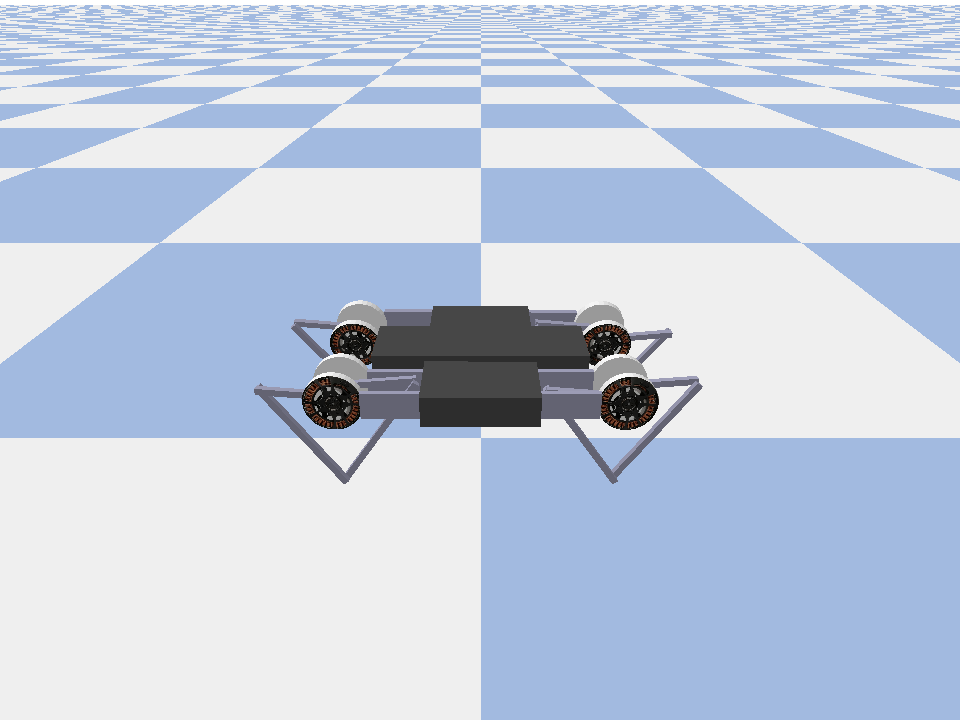

In [5]:
env = suite_pybullet.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In this environment the goal is for the agent to train a policy that will control the Minitaur robot and have it move forward as fast as possible. Episodes last 1000 steps and the return will be the sum of rewards throughout the episode.

Let's look at the information the environment provides as an `observation` which the policy will use to generate `actions`.

In [6]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(28,), dtype=dtype('float32'), name='observation', minimum=[  -3.1515927   -3.1515927   -3.1515927   -3.1515927   -3.1515927
   -3.1515927   -3.1515927   -3.1515927 -167.72488   -167.72488
 -167.72488   -167.72488   -167.72488   -167.72488   -167.72488
 -167.72488     -5.71        -5.71        -5.71        -5.71
   -5.71        -5.71        -5.71        -5.71        -1.01
   -1.01        -1.01        -1.01     ], maximum=[  3.1515927   3.1515927   3.1515927   3.1515927   3.1515927   3.1515927
   3.1515927   3.1515927 167.72488   167.72488   167.72488   167.72488
 167.72488   167.72488   167.72488   167.72488     5.71        5.71
   5.71        5.71        5.71        5.71        5.71        5.71
   1.01        1.01        1.01        1.01     ])
Action Spec:
BoundedArraySpec(shape=(8,), dtype=dtype('float32'), name='action', minimum=-1.0, maximum=1.0)


As we can see the observation is fairly complex. We recieve 28 values representing the angles, velocities and torques for all the motors. In return the environment expects 8 values for the actions between `[-1, 1]`. These are the desired motor angles.

Usually we create two environments: one for collecting data during training and one for evaluation. The environments are written in pure python and use numpy arrays, which the Actor Learner API directly consumes.

In [7]:
collect_env = suite_pybullet.load(env_name)
eval_env = suite_pybullet.load(env_name)

urdf_root=/tmpfs/src/tf_docs_env/lib/python3.6/site-packages/pybullet_data
urdf_root=/tmpfs/src/tf_docs_env/lib/python3.6/site-packages/pybullet_data


## Distribution Strategy
We use the DistributionStrategy API to enable running the train step computation across multiple devices such as multiple GPUs or TPUs using data parallelism. The train step:
* Receives a batch of training data
* Splits it across the devices
* Computes the forward step
* Aggregates and computes the MEAN of the loss
* Computes the backward step and performs a gradient variable update

With TF-Agents Learner API and DistributionStrategy API it is quite easy to switch between running the train step on GPUs (using MirroredStrategy) to TPUs (using TPUStrategy) without changing any of the training logic below.

### Enabling the GPU
If you want to try running on a GPU, you'll first need to enable GPUs for the notebook:

* Navigate to Edit→Notebook Settings
* Select GPU from the Hardware Accelerator drop-down

### Picking a strategy
Use `strategy_utils` to generate a strategy. Under the hood, passing the parameter:
* `use_gpu = False` returns `tf.distribute.get_strategy()`, which uses CPU
* `use_gpu = True` returns `tf.distribute.MirroredStrategy()`, which uses all GPUs that are visible to TensorFlow on one machine

In [8]:
use_gpu = True #@param {type:"boolean"}

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


All variables and Agents need to be created under `strategy.scope()`, as you'll see below.

## Agent

To create an SAC Agent, we first need to create the networks that it will train. SAC is an actor-critic agent, so we will need two networks.

The critic will give us value estimates for `Q(s,a)`. That is, it will recieve as input an observation and an action, and it will give us an estimate of how good that action was for the given state.


In [9]:
observation_spec, action_spec, time_step_spec = (
      spec_utils.get_tensor_specs(collect_env))

with strategy.scope():
  critic_net = critic_network.CriticNetwork(
        (observation_spec, action_spec),
        observation_fc_layer_params=None,
        action_fc_layer_params=None,
        joint_fc_layer_params=critic_joint_fc_layer_params,
        kernel_initializer='glorot_uniform',
        last_kernel_initializer='glorot_uniform')

We will use this critic to train an `actor` network which will allow us to generate actions given an observation.

The `ActorNetwork` will predict parameters for a tanh-squashed [MultivariateNormalDiag](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalDiag) distribution. This distribution will then be sampled, conditioned on the current observation, whenever we need to generate actions.

In [10]:
with strategy.scope():
  actor_net = actor_distribution_network.ActorDistributionNetwork(
      observation_spec,
      action_spec,
      fc_layer_params=actor_fc_layer_params,
      continuous_projection_net=(
          tanh_normal_projection_network.TanhNormalProjectionNetwork))

With these networks at hand we can now instantiate the agent.


In [11]:
with strategy.scope():
  train_step = train_utils.create_train_step()

  tf_agent = sac_agent.SacAgent(
        time_step_spec,
        action_spec,
        actor_network=actor_net,
        critic_network=critic_net,
        actor_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=actor_learning_rate),
        critic_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=critic_learning_rate),
        alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=alpha_learning_rate),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        td_errors_loss_fn=tf.math.squared_difference,
        gamma=gamma,
        reward_scale_factor=reward_scale_factor,
        train_step_counter=train_step)

  tf_agent.initialize()

## Replay Buffer

In order to keep track of the data collected from the environment, we will use [Reverb](https://deepmind.com/research/open-source/Reverb), an efficient, extensible, and easy-to-use replay system by Deepmind. It stores experience data collected by the Actors and consumed by the Learner during training.

In this tutorial, this is less important than `max_size` -- but in a distributed setting with async collection and training, you will probably want to experiment with `rate_limiters.SampleToInsertRatio`, using a samples_per_insert somewhere between 2 and 1000. For example:
```
rate_limiter=reverb.rate_limiters.SampleToInsertRatio(samples_per_insert=3.0, min_size_to_sample=3, error_buffer=3.0))
```




In [12]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

The replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using `tf_agent.collect_data_spec`.

Since the SAC Agent needs both the current and next observation to compute the loss, we set `sequence_length=2`.

In [13]:
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

Now we generate a TensorFlow dataset from the Reverb replay buffer. We will pass this to the Learner to sample experiences for training.

In [14]:
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

## Policies

In TF-Agents, policies represent the standard notion of policies in RL: given a `time_step` produce an action or a distribution over actions. The main method is `policy_step = policy.step(time_step)` where `policy_step` is a named tuple `PolicyStep(action, state, info)`.  The `policy_step.action` is the `action` to be applied to the environment, `state` represents the state for stateful (RNN) policies and `info` may contain auxiliary information such as log probabilities of the actions.

Agents contain two policies:

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.

In [15]:
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

In [16]:
tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

Policies can be created independently of agents. For example, use `tf_agents.policies.random_py_policy` to create a policy which will randomly select an action for each time_step.

In [17]:
random_policy = random_py_policy.RandomPyPolicy(
  collect_env.time_step_spec(), collect_env.action_spec())

## Actors
The actor manages interactions between a policy and an environment.
  * The Actor components contain an instance of the environment (as `py_environment`) and a copy of the policy variables.
  * Each Actor worker runs a sequence of data collection steps given the local values of the policy variables.
  * Variable updates are done explicitly using the variable container client instance in the training script before calling `actor.run()`.
  * The observed experience is written into the replay buffer in each data collection step.

As the Actors run data collection steps, they pass trajectories of (state, action, reward) to the observer, which caches and writes them to the Reverb replay system. 

We're storing trajectories for frames [(t0,t1) (t1,t2) (t2,t3), ...] because `stride_length=1`.

In [18]:
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=2,
  stride_length=1)

We create an Actor with the random policy and collect experiences to seed the replay buffer with.

In [19]:
initial_collect_actor = actor.Actor(
  collect_env,
  random_policy,
  train_step,
  steps_per_run=initial_collect_steps,
  observers=[rb_observer])
initial_collect_actor.run()

Instantiate an Actor with the collect policy to gather more experiences during training.

In [20]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
  collect_env,
  collect_policy,
  train_step,
  steps_per_run=1,
  metrics=actor.collect_metrics(10),
  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
  observers=[rb_observer, env_step_metric])

Create an Actor which will be used to evaluate the policy during training. We pass in `actor.eval_metrics(num_eval_episodes)` to log metrics later.

In [21]:
eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

## Learners
The Learner component contains the agent and performs gradient step updates to the policy variables using experience data from the replay buffer. After one or more training steps, the Learner can push a new set of variable values to the variable container.

In [22]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


Instructions for updating:
rename to distribute_datasets_from_function


Instructions for updating:
rename to distribute_datasets_from_function


## Metrics and Evaluation

We instantiated the eval Actor with `actor.eval_metrics` above, which creates most commonly used metrics during policy evaluation:
* Average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes.
* Average episode length.

We run the Actor to generate these metrics.

In [23]:
def get_eval_metrics():
  eval_actor.run()
  results = {}
  for metric in eval_actor.metrics:
    results[metric.name] = metric.result()
  return results

metrics = get_eval_metrics()

In [24]:
def log_eval_metrics(step, metrics):
  eval_results = (', ').join(
      '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
  print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

step = 0: AverageReturn = -0.346627, AverageEpisodeLength = 86.349998


Check out the [metrics module](https://github.com/tensorflow/agents/blob/master/tf_agents/metrics/tf_metrics.py) for other standard implementations of different metrics.

## Training the agent

The training loop involves both collecting data from the environment and optimizing the agent's networks. Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

In [25]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = get_eval_metrics()["AverageReturn"]
returns = [avg_return]

for _ in range(num_iterations):
  # Training.
  collect_actor.run()
  loss_info = agent_learner.run(iterations=1)

  # Evaluating.
  step = agent_learner.train_step_numpy

  if eval_interval and step % eval_interval == 0:
    metrics = get_eval_metrics()
    log_eval_metrics(step, metrics)
    returns.append(metrics["AverageReturn"])

  if log_interval and step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))

rb_observer.close()
reverb_server.stop()

step = 5000: loss = -56.69059753417969


step = 10000: AverageReturn = -0.472410, AverageEpisodeLength = 164.899994
step = 10000: loss = -54.17033004760742


step = 15000: loss = -28.52847671508789


step = 20000: AverageReturn = -0.172086, AverageEpisodeLength = 93.349998
step = 20000: loss = -20.480314254760742


step = 25000: loss = -12.228870391845703


step = 30000: AverageReturn = -0.775230, AverageEpisodeLength = 251.449997
step = 30000: loss = -7.371895790100098


step = 35000: loss = -5.757593154907227


step = 40000: AverageReturn = -1.189717, AverageEpisodeLength = 330.600006
step = 40000: loss = -2.23077654838562


step = 45000: loss = -2.0682435035705566


step = 50000: AverageReturn = -1.436991, AverageEpisodeLength = 592.700012
step = 50000: loss = 2.793757438659668


step = 55000: loss = 0.9165877103805542


step = 60000: AverageReturn = -1.421196, AverageEpisodeLength = 630.849976
step = 60000: loss = -1.5204321146011353


step = 65000: loss = 1.119447112083435


step = 70000: AverageReturn = -0.937966, AverageEpisodeLength = 574.400024
step = 70000: loss = 4.193424224853516


step = 75000: loss = 4.100306034088135


step = 80000: AverageReturn = 0.252701, AverageEpisodeLength = 527.799988
step = 80000: loss = -1.2829862833023071


step = 85000: loss = -3.3187692165374756


step = 90000: AverageReturn = 1.051066, AverageEpisodeLength = 614.000000
step = 90000: loss = -0.4716823101043701


step = 95000: loss = 0.616091251373291


step = 100000: AverageReturn = 0.888614, AverageEpisodeLength = 376.600006
step = 100000: loss = -0.057090915739536285


## Visualization


### Plots

We can plot average return vs global steps to see the performance of our agent. In `Minitaur`, the reward function is based on how far the minitaur walks in 1000 steps and penalizes the energy expenditure.

(-1.5613936901092529, 1.175468635559082)

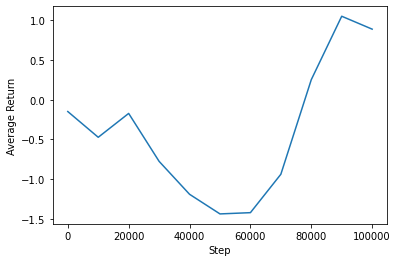

In [26]:
#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()

### Videos

It is helpful to visualize the performance of an agent by rendering the environment at each step. Before we do that, let us first create a function to embed videos in this colab.

In [27]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

The following code visualizes the agent's policy for a few episodes:

In [28]:
num_episodes = 3
video_filename = 'sac_minitaur.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_env.render())
    while not time_step.is_last():
      action_step = eval_actor.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_env.render())

embed_mp4(video_filename)